In [ ]:
from IPython.display import Image

In [ ]:
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Download lvis helmets

In [ ]:
from pycocotools.coco import COCO
import requests
from tqdm.notebook import tqdm
import os

In [ ]:
def download_coco_images(coco_json_path, output_dir, category='helmet'):
  coco = COCO(coco_json_path)
  catIds = coco.getCatIds(catNms=[category])
  imgIds = coco.getImgIds(catIds=catIds)
  images = coco.loadImgs(imgIds)  

  # Save the images into a local folder
  for im in tqdm(images):
    img_data = requests.get(im['coco_url']).content
    with open(output_dir + str(im['id']) + '.jpg', 'wb') as handler:
      handler.write(img_data)


In [ ]:
download_coco_images('drive/MyDrive/nn/dz6/lvis_v1_train.json', 'drive/MyDrive/nn/dz6/lvis_dataset/images/train/')
download_coco_images('drive/MyDrive/nn/dz6/lvis_v1_val.json', 'drive/MyDrive/nn/dz6/lvis_dataset/images/val/')

directory not empty
directory not empty


# Task

* Используем dataset LVIS [link](https://www.lvisdataset.org/)

* [Репозиторий YOLOv5](https://github.com/ultralytics/yolov5)

* [Конфигурационный файл](https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml)

# FasterRCNN

## import

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import torchvision
import torch
import PIL
from PIL import Image
import json
from pycocotools.coco import COCO

In [ ]:
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

def save_to_json(filename, data):
    with open(filename, 'w') as f:
        return json.dump(data, f)
    
def load_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True,
                            num_classes=91, pretrained_backbone=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight en

  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
from torchvision import transforms
import cv2

to_tensor = transforms.ToTensor()

def val_transform(img):
    img_tensor = to_tensor(img)
    return img_tensor.unsqueeze(0)

def visualize_prediction(file, model, device='cuda', verbose=True, thresh=0.0, n_colors=None):
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device)) # list of size 1
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    for i in range(len(prediction['boxes'])):
        x1, x2, x3, x4 = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        name = coco_id_to_name[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:
            image = cv2.rectangle(img, (x1, x2), (x3, x4), np.array(color) * 255, 2)
            cv2.putText(image, name, (x1, x2-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
    show_image(image)
    return prediction

def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install lvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9499viq1
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9499viq1
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=304489 sha256=fa75e44de79913c3397323760fc37de6ea7943810969fb7b70c1236294ab1389
  Stored in directory: /tmp/pip-ephem-wheel-cache-yi_u2hle/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
from torchvision import transforms
import lvis


class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, images_path, transforms=None):
        self.transforms = transforms
        self.images_path = images_path
        self.lvis_api_data = lvis.LVIS(data_dict_file)

        self.imgs = self.lvis_api_data.load_imgs(list(set(self.lvis_api_data.cat_img_map[556])))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.images_path + f'{self.imgs[idx]["id"]}.jpg'
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError as f:
            self.lvis_api_data.download(self.images_path, self.imgs[idx]['id'])
            img = Image.open(img_path).convert("RGB")
        w, h = img.size

        objs = []
        for i in self.lvis_api_data.img_ann_map[self.imgs[idx]['id']]:
            if i['category_id'] == 556:
                objs.append(i)

        num_objs = len(objs)
        boxes = []
        for i in objs:
            bbox = i['bbox']
            xmin = bbox[0]
            ymin = bbox[1]
            xdelt = bbox[2]
            ydelt = bbox[3]
            boxes.append([xmin, ymin, xmin+xdelt, ymin+ydelt])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((num_objs,), dtype=torch.int64)
        

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

def visualize_from_dataset(dataset: DetectionDataset, idx):
    img, boxes = dataset[idx]
    img = torch.swapaxes(img, 0, 2)
    img = torch.swapaxes(img, 0, 1)
    img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2RGB)
    for i in boxes['boxes']:
        x_min, y_min, x_max, y_max = i[0], i[1], i[2], i[3]
        img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    show_image(img)

In [ ]:
img_transforms = transforms.Compose([
    transforms.ToTensor()
])


In [ ]:
train_dataset = DetectionDataset('drive/MyDrive/lvis_v1_train.json', 'drive/MyDrive/lvis_dataset/images/train/', img_transforms)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:

data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=collate_fn, drop_last=True)

## model preparing

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [ ]:
num_classes = 2
in_channels = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels, num_classes=num_classes)

In [ ]:
assert model.roi_heads.box_predictor.cls_score.in_features == 1024
assert model.roi_heads.box_predictor.cls_score.out_features == 2
assert model.roi_heads.box_predictor.bbox_pred.out_features == 8

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
    
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [ ]:
device

device(type='cuda')

## train

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=30,
                                               gamma=0.1)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import math
import sys
import time
import torch

# from coco_utils import get_coco_api_from_dataset
# from coco_eval import CocoEvaluator
# import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        # lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # получим предсказания сети (словарь)        
        loss_dict = model(images, targets)
        # cложим их
        losses = sum(value for value in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            #print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        # metric_logger.update(loss=losses, **loss_dict)
        # metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [ ]:
def train(model, num_epochs=10, state_path=None):
    if state_path is not None:
        model.load_state_dict(torch.load(state_path, map_location=torch.device('cpu')))
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        lr_scheduler.step()
    torch.save(model.state_dict(), 'drive/MyDrive/lvis_dataset/model_state_dict2.pth')

In [ ]:
train(model, 'drive/MyDrive/lvis_dataset/model_state_dict2.pth')

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

## visualize

In [ ]:
def visualize_prediction_helmet(file, model, device='cuda', verbose=False, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device)) # list of size 1
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        # name = id_to_name[label]
        name = 'helmet'
        color = palette[label]
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:
            image = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            cv2.putText(image, name, (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
    show_image(image)
    return prediction

# YOLOv5

## create yolo annotations

In [ ]:
def make_annotations(annotation_path, output_dir):
    if len(os.listdir(output_dir)) != 0:
        return

    lvis_api_data = lvis.LVIS(annotation_path)
    imgs = lvis_api_data.load_imgs(list(set(lvis_api_data.cat_img_map[556])))
    for idx in range(len(imgs)): 
        print_buffer = []   
        for i in lvis_api_data.img_ann_map[imgs[idx]['id']]:
            if i['category_id'] == 556:
                b_center_x = (i["bbox"][0] + i["bbox"][2]) / 2 
                b_center_y = (i["bbox"][1] + i["bbox"][3]) / 2
                b_width    = (i["bbox"][2] - i["bbox"][0])
                b_height   = (i["bbox"][3] - i["bbox"][1])    
                image_w, image_h = imgs[idx]["width"], imgs[idx]["height"]  
                b_center_x /= image_w 
                b_center_y /= image_h 
                b_width    /= image_w 
                b_height   /= image_h 
                print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(0, b_center_x, b_center_y, b_width, b_height))

        save_file_name = f'{output_dir}/{imgs[idx]["id"]}.txt'
        # print(len(print_buffer), end=';')

        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
make_annotations('drive/MyDrive/lvis_v1_train.json', 'drive/MyDrive/lvis_dataset/labels/train')

In [ ]:
make_annotations('drive/MyDrive/lvis_v1_val.json', 'drive/MyDrive/lvis_dataset/labels/val')

In [ ]:
assert len(os.listdir('drive/MyDrive/lvis_dataset/labels/train')) == len(os.listdir('drive/MyDrive/lvis_dataset/images/train'))
assert len(os.listdir('drive/MyDrive/lvis_dataset/labels/val')) == len(os.listdir('drive/MyDrive/lvis_dataset/images/val'))

## setup

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 14474, done.
remote: Total 14474 (delta 0), reused 0 (delta 0), pack-reused 14474
Receiving objects: 100% (14474/14474), 13.62 MiB | 7.61 MiB/s, done.
Resolving deltas: 100% (9978/9978), done.


In [ ]:
!cd yolov5 && pip install -r requirements.txt  # install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 28.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.3 MB/s 


## train

In [ ]:
!cd yolov5 && python -O train.py --batch 64 --cfg ../drive/MyDrive/yolo.yaml --data ../drive/MyDrive/lvis.yaml --weights yolov5s.pt --epoch 100

train: weights=yolov5s.pt, cfg=../drive/MyDrive/yolo.yaml, data=../drive/MyDrive/lvis.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma

In [ ]:
model_path = './yolov5/runs/train/exp2/weights/best.pt'
yolo_path = 'yolov5'
model = torch.hub.load(yolo_path, 'custom', path=model_path, source='local')

YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
yolo summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
!ls

drive  sample_data  yolov5


# Yolo vs FasterRcnn

In [ ]:
yolo_path = 'drive/MyDrive/lvis_dataset/yolov5'
yolo_model_path = 'drive/MyDrive/lvis_dataset/best.pt'
faster_rcnn_path ='drive/MyDrive/lvis_dataset/model_state_dict2.pth' 

In [ ]:
yolo_model = torch.hub.load(yolo_path, 'custom', path=yolo_model_path, source='local')

requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 2 packages updated per /content/drive/MyDrive/lvis_dataset/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
yolo summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
num_classes = 2
in_channels = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels, num_classes=num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
faster_rcnn_model.to(device)
faster_rcnn_model.load_state_dict(torch.load(faster_rcnn_path, map_location=torch.device('cpu')))

<All keys matched successfully>

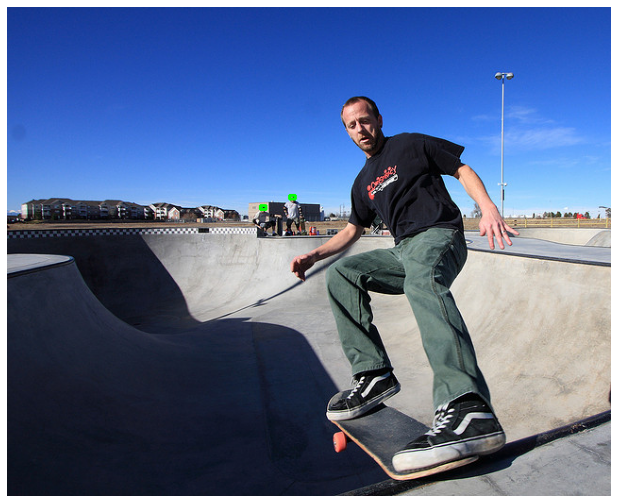

In [ ]:
visualize_from_dataset(train_dataset, 2)